In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import cv2
import matplotlib.image as mpimg
from matplotlib import path
from scipy.spatial.transform import Rotation 
from mpl_toolkits.mplot3d import Axes3D

In [3]:
DATA_DIR =  "data/data.mat"

data = sio.loadmat(DATA_DIR)['data']

In [4]:
x1 = data['x1'][0][0]; x2 = data['x2'][0][0]
x3 = data['x3'][0][0]; K = data['K'][0][0]
C = data['C'][0][0]; R = data['R'][0][0]
img1 = data['img1'][0][0].astype(np.uint8)
img2 = data['img2'][0][0].astype(np.uint8)
img3 = data['img3'][0][0].astype(np.uint8)

**Estimate Fundamental Matrix**

In [5]:
from estimate_fundamental_matrix import estimateFundamentalMatrix_RANSAC

#F, inliers1, inliers2 = estimateFundamentalMatrix_RANSAC(x1,x2, num_iter=4)
#my implementation is very very slow right now and does not give great solution
F, mask = cv2.findFundamentalMat(x1,x2,cv2.RANSAC)

In [6]:
#select only inlier points
inliers_left = x1[mask.ravel()==1].astype(int)
inliers_right = x2[mask.ravel()==1].astype(int)

**Visualisation of epipoles and epipolar lines**

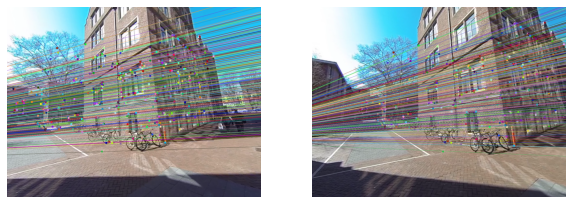

In [25]:
from helper import draw_epipolar_lines_using_FundamentalMatrix

draw_epipolar_lines_using_FundamentalMatrix(F, img1.copy(), img2.copy(), 
                                            inliers_left, inliers_right, 
                                            figSize=(10,5), color=True)

**Essential Matrix from Fundamental Matrix**

In [26]:
def EssentialMatrixFromFundamentalMatrix(K1,F,K2):
    '''
       :param K1 : instrinsics of the first camera
       :param K2 : intrinsic of the second camera
       :param F: fundamental matrix
       
       Key Step is to ensure that singularity of the Essential Matrix. Enforce the singular va
       
       Returns:
           E : Essential Matrix
    '''
    E = K2.T @ F @ K1
    U, _ ,VT = np.linalg.svd(E)
    S = np.diag(np.array([1, 1, 0]))
    
    E = U @ S  @ VT
    
    return E

In [27]:
E = EssentialMatrixFromFundamentalMatrix(K,F,K)

In [28]:
E_, __ = cv2.findEssentialMat(x1,x2,K)